In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score

### > **LOADING THE DATASET**

In [2]:
df_train = pd.read_csv(r'../input/jobathon-may-2021-credit-card-lead-prediction/train.csv')
df_test = pd.read_csv(r'../input/jobathon-may-2021-credit-card-lead-prediction/test.csv')

In [3]:
df_train.shape, df_test.shape

((245725, 11), (105312, 10))

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245725 entries, 0 to 245724
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ID                   245725 non-null  object
 1   Gender               245725 non-null  object
 2   Age                  245725 non-null  int64 
 3   Region_Code          245725 non-null  object
 4   Occupation           245725 non-null  object
 5   Channel_Code         245725 non-null  object
 6   Vintage              245725 non-null  int64 
 7   Credit_Product       216400 non-null  object
 8   Avg_Account_Balance  245725 non-null  int64 
 9   Is_Active            245725 non-null  object
 10  Is_Lead              245725 non-null  int64 
dtypes: int64(4), object(7)
memory usage: 20.6+ MB


In [5]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105312 entries, 0 to 105311
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ID                   105312 non-null  object
 1   Gender               105312 non-null  object
 2   Age                  105312 non-null  int64 
 3   Region_Code          105312 non-null  object
 4   Occupation           105312 non-null  object
 5   Channel_Code         105312 non-null  object
 6   Vintage              105312 non-null  int64 
 7   Credit_Product       92790 non-null   object
 8   Avg_Account_Balance  105312 non-null  int64 
 9   Is_Active            105312 non-null  object
dtypes: int64(3), object(7)
memory usage: 8.0+ MB


In [6]:
data = pd.concat([df_train,df_test],ignore_index=True)

In [7]:
data.describe(include='all')

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
count,351037,351037,351037.000000,351037,351037,351037,351037.000000,309190,3.510370e+05,351037,245725.000000
unique,351037,2,NaN,35,4,4,NaN,2,NaN,2,NaN
top,TWKBG3VM,Male,NaN,RG268,Self_Employed,X1,NaN,No,NaN,No,NaN
freq,1,191902,NaN,51059,144078,148202,NaN,205965,NaN,214087,NaN
mean,NaN,NaN,43.860716,NaN,NaN,NaN,46.924244,NaN,1.130141e+06,NaN,0.237208
std,NaN,NaN,14.841932,NaN,NaN,NaN,32.329303,NaN,8.569530e+05,NaN,0.425372
min,NaN,NaN,23.000000,NaN,NaN,NaN,7.000000,NaN,2.079000e+04,NaN,0.000000
25%,NaN,NaN,30.000000,NaN,NaN,NaN,20.000000,NaN,6.041850e+05,NaN,0.000000
50%,NaN,NaN,43.000000,NaN,NaN,NaN,32.000000,NaN,8.951620e+05,NaN,0.000000
75%,NaN,NaN,54.000000,NaN,NaN,NaN,73.000000,NaN,1.368152e+06,NaN,0.000000


Checking if there is any null values in the dataset.

In [8]:
data.isnull().sum()

ID                          0
Gender                      0
Age                         0
Region_Code                 0
Occupation                  0
Channel_Code                0
Vintage                     0
Credit_Product          41847
Avg_Account_Balance         0
Is_Active                   0
Is_Lead                105312
dtype: int64

In [9]:
data.isna().sum()/df_train.shape[0] *100

ID                      0.000000
Gender                  0.000000
Age                     0.000000
Region_Code             0.000000
Occupation              0.000000
Channel_Code            0.000000
Vintage                 0.000000
Credit_Product         17.030013
Avg_Account_Balance     0.000000
Is_Active               0.000000
Is_Lead                42.857666
dtype: float64

### TREATING THE MISSING VALUES

**About 17% missing values are from credit_product.Since the missing value is categorical, the missing values are imputed using mode.**

In [10]:
data['Credit_Product']=data['Credit_Product'].fillna(data['Credit_Product'].mode()[0])

**Visualizing the outliers using boxplot.**

Most of the data is categorical in nature.The outliers are visualized for avg_account_balance only.

<AxesSubplot:xlabel='Avg_Account_Balance'>

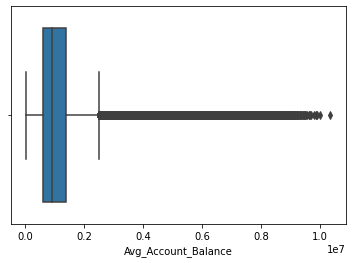

In [11]:
sns.boxplot(data['Avg_Account_Balance'])

<AxesSubplot:xlabel='Age'>

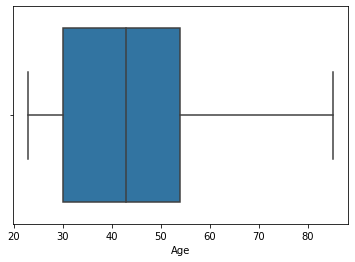

In [12]:
sns.boxplot(data['Age'])

<AxesSubplot:xlabel='Vintage'>

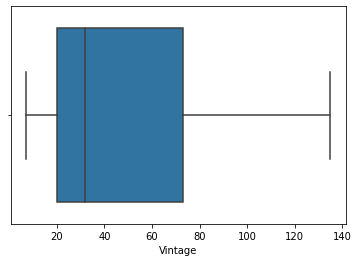

In [13]:
sns.boxplot(data['Vintage'])

**Visulaizing outliers using distplot.**

<AxesSubplot:xlabel='Avg_Account_Balance', ylabel='Density'>

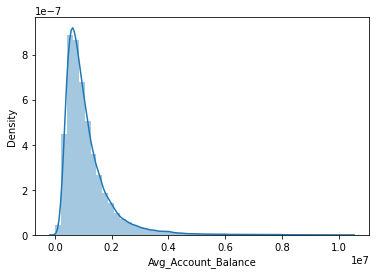

In [14]:
sns.distplot(data['Avg_Account_Balance'])

**INFERENCE**

The boxplot shows there are outliers but using distplot the graph is of form log normal and have positive outliers.To treat the outliers, boxcox transformation or log transformation is used to get normal distribution.

Using Boxcox-transformation

<AxesSubplot:xlabel='Avg_Account_Balance', ylabel='Density'>

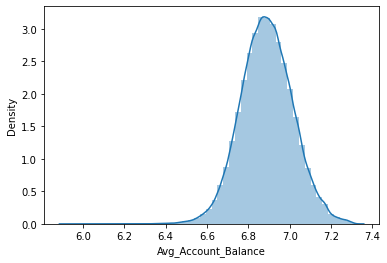

In [15]:
df_train['Avg_Account_Balance'],df_lambda = stats.boxcox(df_train['Avg_Account_Balance'])
df_test['Avg_Account_Balance'],df_lambda = stats.boxcox(df_test['Avg_Account_Balance'])
sns.distplot(df_train['Avg_Account_Balance'])

Using log transformation

<AxesSubplot:xlabel='Avg_Account_Balance', ylabel='Density'>

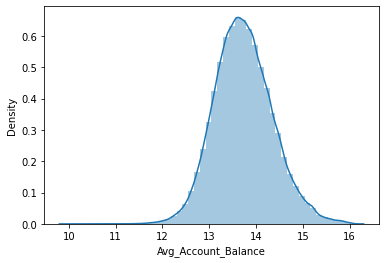

In [16]:
data['Avg_Account_Balance'] = np.log(data['Avg_Account_Balance'])
sns.distplot(data['Avg_Account_Balance'])

<AxesSubplot:xlabel='Avg_Account_Balance'>

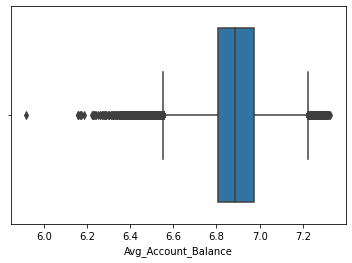

In [17]:
sns.boxplot(df_train['Avg_Account_Balance'])

> # **EXPLORATORY DATA ANALYSIS**

In [18]:
data['Gender'].value_counts()

Male      191902
Female    159135
Name: Gender, dtype: int64

**Channel Code**

<AxesSubplot:xlabel='Channel_Code', ylabel='count'>

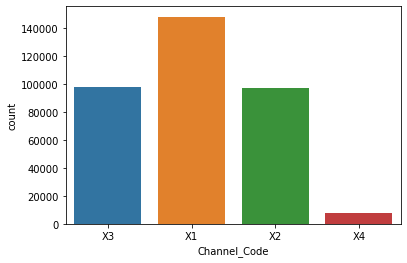

In [19]:
sns.countplot(data['Channel_Code'])

**Analysis:** From the countplot, X1 has 50% occurrence of total data in channel code.X3 and X2 have same number of occurrence in channel code which is about 30%. 

**Occupation**

<AxesSubplot:xlabel='Occupation', ylabel='count'>

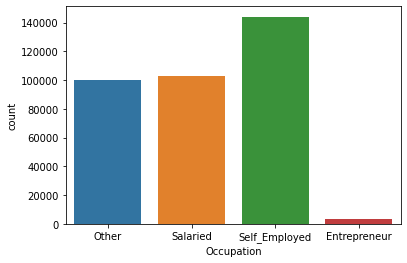

In [20]:
sns.countplot(data['Occupation'])

**Analysis:** From the countplot almost 40% of people are self employed and approx 30% of them are salaried and others.Approx 2% of them are entrepreneurs.

**Occupation vs Age**

<AxesSubplot:xlabel='Occupation', ylabel='Age'>

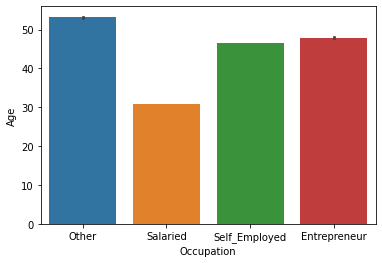

In [21]:
sns.barplot(x='Occupation',y='Age',data=data)

**Analysis:** From the barplot, self_employed and Entrepreneur have almost equal age, while the salaried person have lower age compared to others.

**Gender vs Age**

<AxesSubplot:xlabel='Gender', ylabel='Age'>

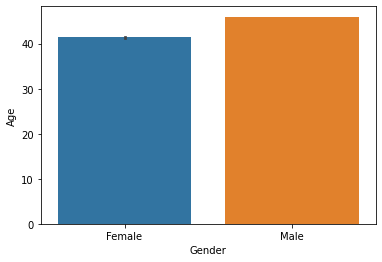

In [22]:
sns.barplot(x='Gender',y='Age',data=data)

**Analysis:** The dataset have more aged male compared that with women.

**Occupation vs Vintage**

<AxesSubplot:xlabel='Occupation', ylabel='Vintage'>

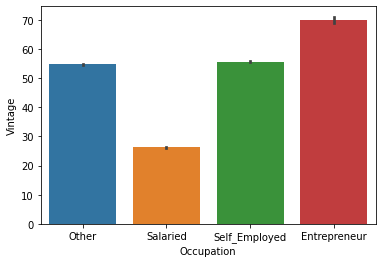

In [23]:
sns.barplot(x='Occupation',y='Vintage',data=data)

**Analysis:** Entreprenuers have higher vintage compared to rest of occupation people.Self employed an others have almost equal vintage with bank.

**Channel Code vs Vintage**

<AxesSubplot:xlabel='Channel_Code', ylabel='Vintage'>

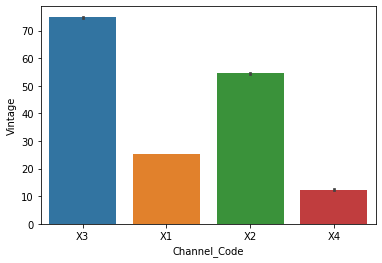

In [24]:
sns.barplot(x='Channel_Code',y='Vintage',data=data)

**Gender vs Age**

<AxesSubplot:xlabel='Gender', ylabel='Vintage'>

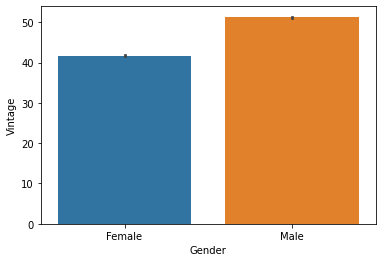

In [25]:
sns.barplot(x='Gender',y='Vintage',data=data)

From the barplot, Male have higher vintage compared that with women

**Is Active vs Vintage**

<AxesSubplot:xlabel='Is_Active', ylabel='Vintage'>

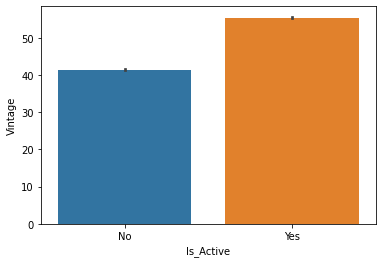

In [26]:
sns.barplot(x='Is_Active',y='Vintage',data=data)

#  > Feature Engineering

**Dropping ID column to train the model to get more accurate result.**

In [27]:
df_train.drop('ID',axis=1,inplace=True)
df = df_test.copy()
df_test.drop("ID",axis=1,inplace = True)

**Using label encoder to convert categorical values in terms of numerical for better processing of data when training them.**

In [28]:
le = LabelEncoder()
categorical = ['Credit_Product','Region_Code','Occupation','Is_Active','Gender','Channel_Code']
for i in categorical:
    df_train[i] = le.fit_transform(df_train[i])
    df_test[i] = le.fit_transform(df_test[i])

In [29]:
X = df_train.drop('Is_Lead',axis=1)
y = df_train['Is_Lead']

# **Using LGBM Classifier to train the model.**

In [35]:
def validation(X, y, model, params, f=10):

    k_folds = StratifiedKFold(n_splits=f, shuffle=True, random_state=25)
    for fold, (train_index, test_index) in enumerate(k_folds.split(X, y)):
        print(f"Fold: {fold}")
        x_test, y_test = X.iloc[test_index], y.iloc[test_index]
        x_train, y_train = X.iloc[train_index], y.iloc[train_index]
        lgb = model(**params)
        lgb.fit(x_train, y_train,
                eval_set=[(x_test, y_test)],
                early_stopping_rounds=100,
                verbose=400)

        pred = lgb.predict_proba(x_test)[:, 1]
        roc_score = roc_auc_score(y_test, pred)
        print(f"roc_auc_score: {roc_score}")
        print("-"*50)
    
    return lgb

In [36]:
lgb_params= {'learning_rate': 0.042312, 
             'n_estimators': 20000, 
             'reg_alpha': 8.45768,  
             'max_bin': 97,
             'reg_lambda': 6.852211,
             'num_leaves': 10, 
             'max_depth': 28, 
             'subsample': 0.751144}



In [37]:
from lightgbm import LGBMClassifier
lgb_model = validation(X, y, LGBMClassifier, lgb_params)

Fold: 0
Training until validation scores don't improve for 100 rounds
[400]	valid_0's binary_logloss: 0.34683
Early stopping, best iteration is:
[670]	valid_0's binary_logloss: 0.346761
roc_auc_score: 0.870508708609366
--------------------------------------------------
Fold: 1
Training until validation scores don't improve for 100 rounds
[400]	valid_0's binary_logloss: 0.340037
[800]	valid_0's binary_logloss: 0.339673
Early stopping, best iteration is:
[816]	valid_0's binary_logloss: 0.33966
roc_auc_score: 0.8769913686384332
--------------------------------------------------
Fold: 2
Training until validation scores don't improve for 100 rounds
[400]	valid_0's binary_logloss: 0.344534
Early stopping, best iteration is:
[560]	valid_0's binary_logloss: 0.344399
roc_auc_score: 0.8735956551444435
--------------------------------------------------
Fold: 3
Training until validation scores don't improve for 100 rounds
[400]	valid_0's binary_logloss: 0.338054
[800]	valid_0's binary_logloss: 0.3

In [38]:
pred_test_lgb = lgb_model.predict_proba(df_test)[:,1]

<AxesSubplot:ylabel='Density'>

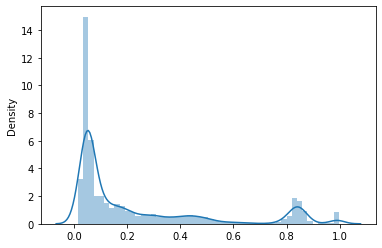

In [40]:
sns.distplot(pred_test_lgb)

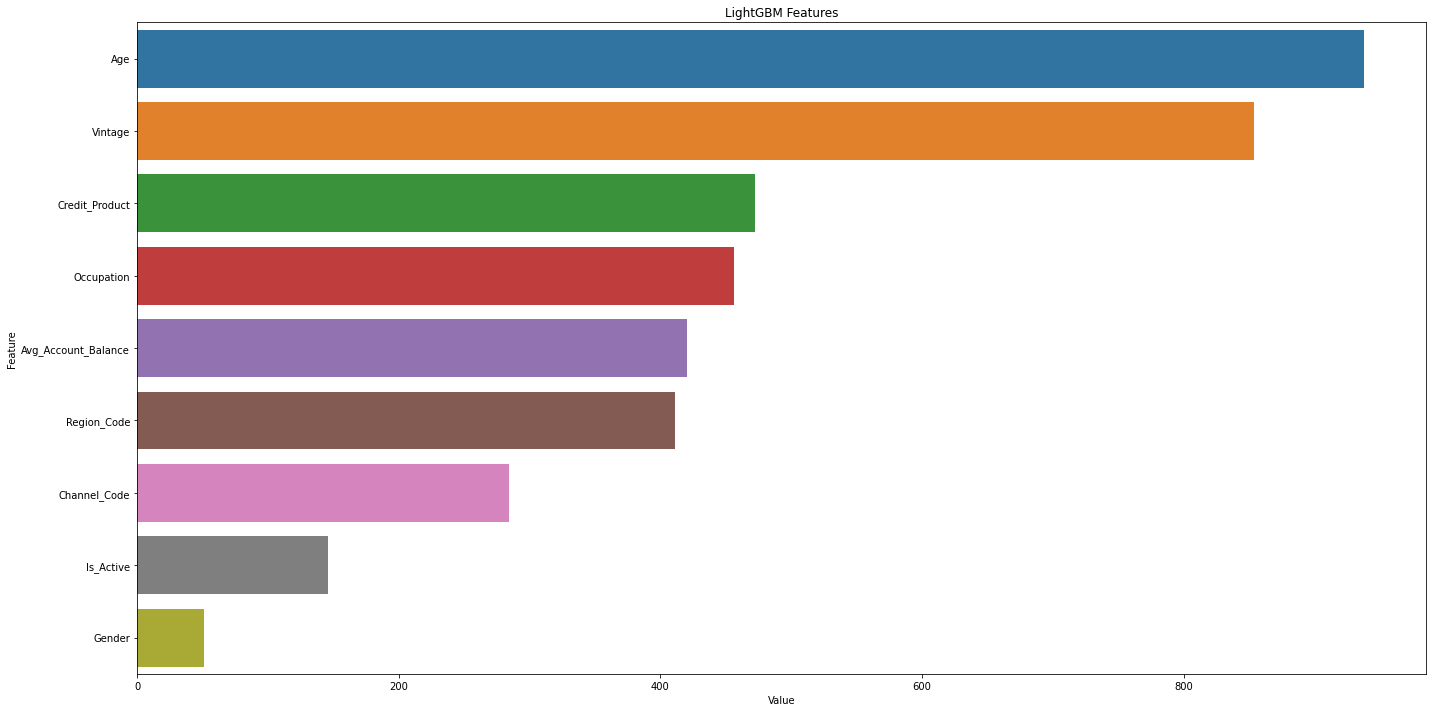

<Figure size 432x288 with 0 Axes>

In [44]:
feature_imp = pd.DataFrame(sorted(zip(lgb_model.feature_importances_,X.columns)), columns=['Value','Feature'])
plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()
plt.savefig('importances.png')

In [39]:
submission = pd.DataFrame(data = {'ID': df["ID"], 'Is_Lead': pred_test_lgb})
submission.to_csv("day_2_11.csv", index = False)
submission.head()

,ID,Is_Lead
0,VBENBARO,0.051347
1,CCMEWNKY,0.849920
2,VK3KGA9M,0.054063
3,TT8RPZVC,0.023380
4,SHQZEYTZ,0.023291
